# MyMDB Analyzer
This notebook accesses the IMDb-Scraping pipeline consisting of the webscraper, the database connector and provides a GUI for the interactive visualization.

![IMDb Logo](https://upload.wikimedia.org/wikipedia/commons/thumb/6/69/IMDB_Logo_2016.svg/440px-IMDB_Logo_2016.svg.png)

[Wikipedia IMDb Definition](https://en.wikipedia.org/wiki/IMDb):

IMDb (an acronym for `I`nternet `M`ovie `D`ata`b`ase) is an online database of information related to films, television series, podcasts, home videos, video games, and streaming content online – including cast, production crew and personal biographies [...]

This notebook visually explores rankings of movies and actors and 

## USAGE
Step through this notebook manually so everything is executed in order

#### OVERCOMING TECHNICAL DIFFICULTIES

In [1]:
# workarround for using event_loops in notebooks (ipykernel already uses the global non-reentrant one)
import nest_asyncio
nest_asyncio.apply()

#### Imports

In [2]:
import db
import analyze
import ui
import numpy as np
import matplotlib.pyplot as plt

connecting to db via conn_str: DRIVER=SQL Server;SERVER=localhost;PORT=1433;DATABASE=MyMDB;UID=SA;PWD=Pr0dRdyPw!


### SCRAPING
Challenges were respecting the site's scraping rules located in robots.txt, not getting timed out even though we followed through and handling those timeouts as well as handling (rather omitting a ton of) missing/format-inhomogenous data as well as asynchronous caching in python.

In [3]:
movies = []
import_ui = ui.init_ui(movies)
import_ui

top3.pkl   ( 1kb)
top5.pkl   ( 1kb)
top10.pkl  ( 3kb)
top50.pkl  ( 7kb)
top100.pkl (39kb)


100 movies acquired

In [5]:
movies = import_ui.movies
# try:
#     movies = import_ui.movies
# except AttributeError:
#     input("press enter to continue")
#     movies = import_ui.movies

### INSERTION
This part was done purely in the SQL Server Backend, using a stored procedure for parsing the insertion data, and taking care of NaN values and the likes.

A trigger was used to recursively update the average instead of recomputation over several tables for each new insert.

In [6]:
for movie in movies:
    try:
        db.insert_movie(**movie)
    except Exception as e:
        print(f"issue at {movie}\n{e}")
"no duplicates found" if db.check_no_duplicates() else "duplicates in actors detected"

'no duplicates found'

### READING
For further analysis the movies are queried back from the db and converted to dataframes

In [7]:
df_movies = analyze.get_movie_dataframe()
df_actors = analyze.get_actors_dataframe()
df_movie_actors = analyze.get_movie_actors_dataframe()
df_actor_features = analyze.get_actor_feature_dataframe()
df_summary = (
 analyze.get_summary_dataframe()
 .sort_values(by="name")
)

display("movies", df_movies.head())
display("actors", df_actors.head())
display("movie_actors", df_movie_actors.head(5))
display("joined data", df_summary.head(10))
display(
    df_summary
    .drop(["movie_id", "actor_id"], axis=1)
    .describe()
)
display("interesting features for actor analysis", df_actor_features.head())
display(df_actor_features.describe())

'movies'

,id,title,year,genre,rating
0,3,The Dark Knight,2008,Action,9.0
1,4,Der Pate 2,1974,Krimi,9.0
2,8,Pulp Fiction,1994,Krimi,8.8
3,9,Der Herr der Ringe: Die Gefährten,2001,Action,8.8
4,10,Zwei glorreiche Halunken,1966,Abenteuer,8.8


'actors'

,id,name,age,avg_rating
0,17,Christian Bale,49,8.8
1,18,Heath Ledger,44,9.0
2,19,Aaron Eckhart,55,9.0
3,20,Michael Caine,90,8.8
4,21,Maggie Gyllenhaal,45,9.0


'movie_actors'

,movie_id,actor_id
0,3,17
1,3,18
2,3,19
3,3,20
4,3,21


'joined data'

,name,age,avg_rating,movie_id,actor_id,title,year,genre,rating
331,Aamir Khan,58,8.3,84,476,3 Idiots,2009,Komödie,8.3
2,Aaron Eckhart,55,9.0,3,19,The Dark Knight,2008,Action,9.0
75,Adam Goldberg,52,8.6,24,162,Der Soldat James Ryan,1998,Drama,8.6
258,Akemi Yamaguchi,-1,8.5,45,280,Die letzten Glühwürmchen,1988,Animation,8.5
262,Akira Ishihama,88,8.5,46,284,Harakiri,1962,Action,8.5
12,Al Pacino,83,9.0,4,24,Der Pate 2,1974,Krimi,9.0
48,Alan Howard,85,8.8,9,66,Der Herr der Ringe: Die Gefährten,2001,Action,8.8
308,Alanna Ubach,47,8.3,73,426,Coco: Lebendiger als das Leben,2017,Animation,8.3
61,Aldo Giuffrè,99,8.8,10,73,Zwei glorreiche Halunken,1966,Abenteuer,8.8
124,Alec Guinness,109,8.4,29,188,Krieg der Sterne,1977,Action,8.5


,age,avg_rating,year
count,366.000000,366.000000,366.00000
mean,68.663934,8.495355,1989.20765
std,32.269315,0.184926,21.72280
min,-1.000000,8.200000,1931.00000
25%,49.000000,8.300000,1977.00000
50%,67.000000,8.500000,1994.00000
75%,88.000000,8.600000,2006.00000
max,155.000000,9.000000,2019.00000


'interesting features for actor analysis'

,name,age,appearances,avg_rating
0,Talia Shire,77,1,9.0
1,Robert De Niro,79,1,9.0
2,Morgan Freeman,86,1,9.0
3,Michael V. Gazzo,100,1,9.0
4,Maggie Gyllenhaal,45,1,9.0


,age,appearances,avg_rating
count,301.000000,301.000000,301.000000
mean,74.993355,1.132890,8.489037
std,27.918691,0.426944,0.192820
min,18.000000,1.000000,8.200000
25%,55.000000,1.000000,8.300000
50%,70.000000,1.000000,8.500000
75%,92.000000,1.000000,8.600000
max,155.000000,4.000000,9.000000


### Visualization


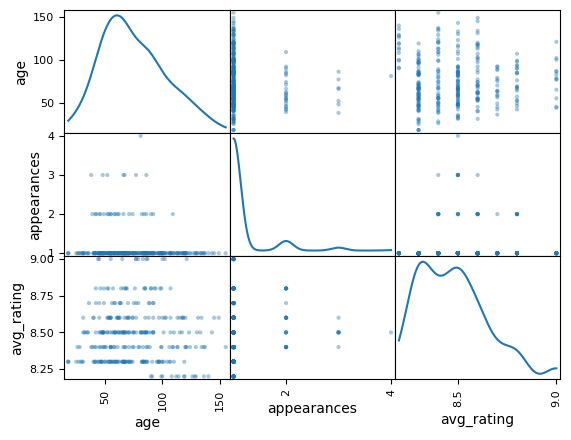

In [11]:
analyze.scattermatrix_actors(
    df_actor_features.drop(df_actor_features[df_actor_features["age"] == -1].index)
)

# outlook

- scrape random movies and try to classify if a given actor could really make it using the top 250 (interesting outliers for certain actors included in top 250 that say only did a single movie)
- try to predict imdb rating